### パッケージのインポート

In [1]:
import csv
import os
from datetime import datetime as dt

import matplotlib.pyplot as plt
import pandas as pd

### 関数の定義

In [2]:
# 波浪テキストデータのcsvファイルへの変換
def txt_csv_converter(filename, writer):
    with open(filename, encoding="shift-jis") as f:
        file = f.readlines()
        for row in file:
            if row[0:4] != "2011":
                continue
            read = []
            read.append(row[0:8])
            read.append(row[9:15])

            if row[17:24] == "9999.99":
                read.append(None)
            else:
                read.append(float(row[17:24]))
            
            if row[26:33] == "9999.99":
                read.append(None)
            else:
                read.append(float(row[26:33]))
            
            if row[35] == "9":
                read.append(None)
            else:
                read.append(float(row[35:42]))

            writer.writerow(read)


# ファイル名のリスト取得
def get_file_data(dir_path) -> list:
    filenames = sorted(os.listdir(dir_path))
    if ".DS_Store" in filenames:
        filenames.remove(".DS_Store")
    return filenames


# 欠損値数の確認
def null_cnt(dir_path, filenames) -> list:
    list = []
    for filename in filenames:
        df = pd.read_csv(dir_path+"/csv/"+filename,
                        names=["date", "time", "observed", "astoro", "deviation"])
        time_dropped_df = df.drop(["date", "time"], axis=1)
        list += [[filename, time_dropped_df.isnull().all(axis=1).sum()]]
    return list


### データの変換と確認

In [3]:
# 波浪データをcsvファイルに変換
filename_path = "../data/tsunami/NOWPHAS_Tsunami_data"
filenames = get_file_data(filename_path+"/raw")

for filename in filenames:
    csv_file = filename_path + "/csv/" + filename[:11] + ".csv"
    with open(csv_file, mode="w", newline="") as fw:
        writer = csv.writer(fw, delimiter=",")
        txt_csv_converter(filename_path+"/raw/"+filename, writer)

In [4]:
# 欠損値数の確認
csv_filenames = get_file_data(filename_path+"/csv")
null_list = null_cnt(filename_path, csv_filenames)

null_df = pd.DataFrame(null_list, columns=["filename", "null_num"])
null_df = null_df[null_df["null_num"] > 0].sort_values("null_num", ascending=False)
null_df

,filename,null_num
33,2011TET802G.csv,69839
38,2011TET811G.csv,444
14,2011TET316T.csv,299
40,2011TET813G.csv,12
41,2011TET815G.csv,12


In [5]:
# データの日時情報の一元化
fig = plt.figure(figsize=(7,3))

test_df = pd.read_csv(filename_path+"/csv/2011TET801G.csv", 
                      names=["date", "time", "observed", "astoro", "deviation"])

test_df["date"] = test_df["date"].astype(str)
test_df["time"] = test_df["time"].astype(str)

for i in range(len(test_df)):
    test_df.loc[i, "time"] = test_df.loc[i, "time"].zfill(6)
    s = test_df.loc[i, "date"] + test_df.loc[i, "time"]
    test_df.loc[i, "datetime"] = dt.strptime(s, "%Y%m%d%H%M%S")

test_df = test_df.drop(["date", "time"], axis=1)

<Figure size 700x300 with 0 Axes>

In [6]:
# 時期を絞る
start = test_df[test_df["datetime"] == dt(2011,3,11,14,30,00)].index[0]
end = test_df[test_df["datetime"] == dt(2011,3,12,00,00,00)].index[0]

cut_test_df = test_df.iloc[start:end].reset_index()

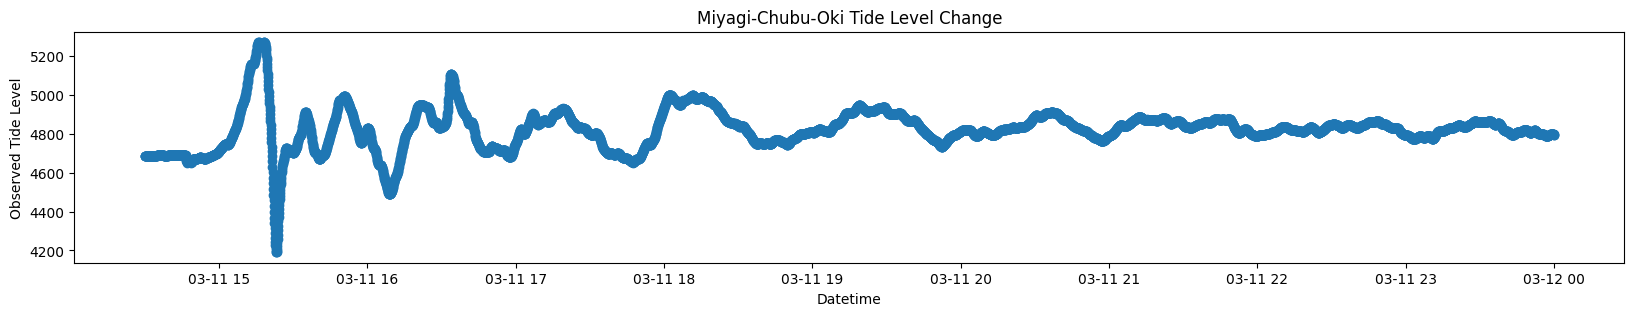

In [7]:
# データの可視化
fig = plt.figure(figsize=(20,3))

plt.scatter(x=cut_test_df["datetime"], y=cut_test_df["observed"])
plt.title("Miyagi-Chubu-Oki Tide Level Change")
plt.xlabel("Datetime")
plt.ylabel("Observed Tide Level")

plt.show()